In [1]:
import pandas as pd
import numpy as np
import time 
import osmnx as omx
import matplotlib.pyplot as plt
import folium

In [16]:
data = pd.read_csv('bike_data_new.csv',parse_dates=['started_at','ended_at'])#, nrows=250)

# Part 1
#### Finding the statistics

In [17]:
global durations # stores time durations of trips as a list



def clean_data():
    # remove trips of zero duration 
    global durations
    durations = data.apply(lambda row: (row['ended_at'] - row['started_at']).seconds//60, axis=1)

    print('\nInitially:', len(data), 'rows')

    # det rows corresponding to zero duration 
    durn_0_rows = durations[durations==0].index

    # drop these rows 
    data.drop(durn_0_rows,axis = 0,inplace=True)
    durations.drop(durn_0_rows,axis = 0,inplace=True)


    print('After deleting `duration 0` rows:', len(data),'rows')


def statistics():
    global durations
    
    print('Maximum duration: ',durations.max(), 'minutes')

    min_durn = durations.min()
    print('Minimum duration: ',min_durn , 'minutes')

    freq_min = np.where(durations==min_durn)[0]
    print('Count of rides of minimum duration: ',len(freq_min))

    circular_trips = np.where((data['start_lat']==data['end_lat']) & (data['start_lng']==data['end_lng']))[0]
    print('Number of circular trips: ', len(circular_trips))

    print('Percentage of round trips: ', 100*len(circular_trips)/len(data),'%')

### Calling `cleaning` and `statistics` functions 

In [18]:
st_t = time.time()
clean_data()
statistics()
en_t = time.time()
print('\nRuntime of functions `clean_data()` and  `Statistics()`: ', en_t-st_t , 'seconds')


Initially: 6867 rows
After deleting `duration 0` rows: 6821 rows
Maximum duration:  518 minutes
Minimum duration:  1 minutes
Count of rides of minimum duration:  89
Number of circular trips:  169
Percentage of round trips:  2.47764257440258 %

Runtime of functions `clean_data()` and  `Statistics()`:  0.14820313453674316 seconds


### Probability Distributions for the ride Duratoins 

Average ride duration: 12.526755607682158 minutes
maximum probable duration: 5.9115 - 6.17 minutes with probability: 0.2813021681534756


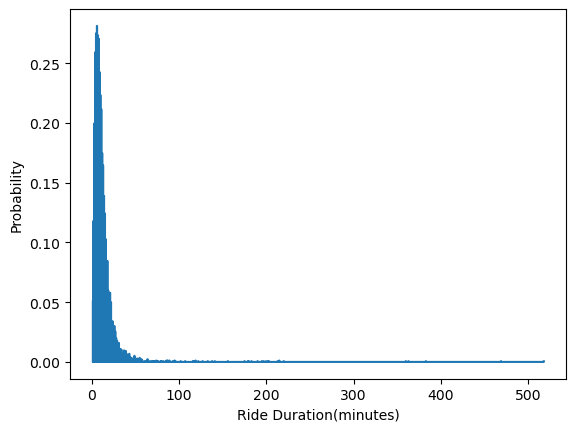

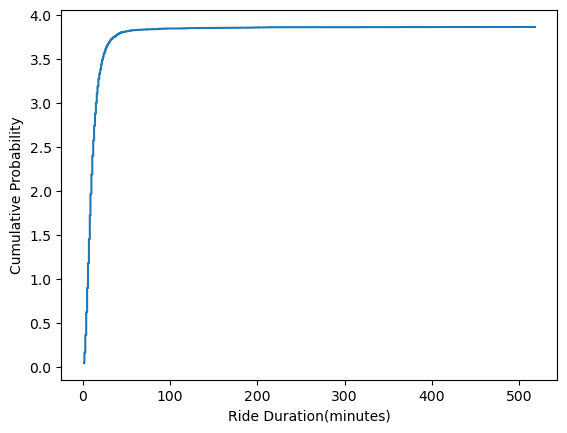

In [19]:
# Finding average ride duratoin: Trivial 
avg_durn = durations.sum()/len(durations)
print('Average ride duration:', avg_durn, 'minutes')


# Make buckets of ride durations. I habe taken 2000 buckets 
counts, bin_edges = np.histogram(durations, bins=2000,density=True)
pdf = counts # Numpy function to get the pdf 


# Computing `bucket` corresponding to max probaility and corresponding `probability`
max_bin = np.argmax(counts)
b_left= bin_edges[max_bin]
b_right = bin_edges[max_bin+1]
print('maximum probable duration:', b_left,'-',b_right,'minutes with probability:', counts[max_bin] )

# Plotting the `pdf`
fig_, ax_ = plt.subplots()
ax_.plot(bin_edges[1:], pdf, drawstyle='steps')
ax_.set_xlabel('Ride Duration(minutes)')
ax_.set_ylabel('Probability')
plt.show()


# plot a `CDF`
fig, ax = plt.subplots()
cdf = np.cumsum(pdf)
ax.plot(bin_edges[1:], cdf, drawstyle='steps')
ax.set_xlabel('Ride Duration(minutes)')
ax.set_ylabel('Cumulative Probability')
plt.show()





# Part 2
### Filtering Data from 06:00 AM to 06:00 PM

In [20]:
st_t = time.time()
filter_low = pd.Timestamp('01-02-2023 06:00')
filter_high = pd.Timestamp('01-02-2023 18:00')
restr  = data.loc[(data['started_at'] >= filter_low)  & (data['ended_at'] <= filter_high)]
restr.reset_index(drop= True,inplace=True)
en_t = time.time()
print('Time for filtering from 06:00 AM to 06:00 PM', en_t-st_t, 'seconds')
print('Rides restricted from 06:00 AM to 06:00 PM:', len(restr), 'rides\n')

Time for filtering from 06:00 AM to 06:00 PM 0.0033447742462158203 seconds
Rides restricted from 06:00 AM to 06:00 PM: 4692 rides




`Naive Algorithm` for counting `feasible pairs`  

In [21]:
def naive_pair_cnt():
    global restr
    cnt = 0
    n = len(restr)
    for i in range (n):
        for j in range (n):
            if j==i or (restr.loc[i]['start_lat'],restr.loc[i]['start_lng'])!= (restr.loc[j]['end_lat'],restr.loc[j]['end_lng']):
                continue
            elif restr.loc[i]['ended_at'] <= restr.loc[j]['started_at']:
                cnt+=1

    return cnt     


`Efficinet Algorithm` for counitng `Feasible Pairs` (Explained in the report)

In [22]:
dict_st = {}
dict_en = {} 

# 2-pointwr methid to get feasible pairs 
def pair_cnt(L_end,L_st):
    global restr
    j  = 0
    cnt = 0
    n = len(L_end)
    m = len(L_st)
    for i in range (n):
        while (j < m) and (restr.loc[L_st[j]]['started_at'] < restr.loc[L_end[i]]['ended_at']):
            j+=1
        cnt+= m - j

    return cnt

# To popolate dict_st and dict_en
def add_to_dict(row):
    global dict_st, dict_en
    dict_st.setdefault((row['start_lat'], row['start_lng']), []).append(row.name)
    dict_en.setdefault((row['end_lat'  ], row['end_lng'  ]), []).append(row.name)


def feasible_pair_cnt():
    global restr

    # To popolate dict_st and dict_en
    restr.loc[:,['start_lat','start_lng','end_lat','end_lng']].apply(add_to_dict, axis=1)
    
    # Input data is already sorted by start time so this is not needed
    # for key in dict_st:
    #     dict_st[key].sort(key = lambda x: data.iloc[x]['started_at'])

    # Sort vecctors correspondint to each key in dict_en by end_time 
    for key in dict_en:
        dict_en[key].sort(key = lambda x: restr.loc[x]['ended_at'])
    
    # The 2-pointer method to get feasible pairs 
    cnt = 0
    for key in dict_en:
        if key in dict_st:
            cnt+= pair_cnt(dict_en[key],dict_st[key])
    return cnt

### Calling the functions for feasible pair count 

In [23]:


st_t = time.time()
ans = feasible_pair_cnt()
en_t = time.time()
print('Number of feasible pairs of rides:', ans)
print('Runtime of `efficient pair count`:', en_t-st_t, 'seconds\n')

# UNCOMMENT THIS TO RUN THE NAIVE METHOD. It takes 3 hrs
# st_t = time.time()
# ans = naive_pair_cnt()
# en_t = time.time()
# print('Number of feasible pairs of rides:', ans)
# print('Runtime of `naive pair count`:', en_t-st_t, 'seconds\n')


print('The naive method takes nore than 3 hrs to terminate and outputs: ')
print('Number of feasible pairs of rides: 43394')
print('Runtime of `naive pair count`: 11835.93357205391 seconds')





Number of feasible pairs of rides: 41518
Runtime of `efficient pair count`: 1.7766740322113037 seconds

The naive method takes nore than 3 hrs to terminate and outputs: 
Number of feasible pairs of rides: 43394
Runtime of `naive pair count`: 11835.93357205391 seconds


# Part 3
#### Dictionalry `depots` to get unique `depots`

In [ ]:
depots = set()

def add_to_set(row):
    depots.add((row['start_lat'], row['start_lng']))
    depots.add((row['end_lat'  ], row['end_lng'  ]))
    
    
def populate_depots(cnt):
    data.iloc[0:cnt, 3:7].apply(add_to_set, axis=1)


#### We are taking top 100 entries 

In [ ]:
first_x = 100
populate_depots(first_x)
n = len(depots)

#### The list of points present in dictionary `depots` is `points`
* Plot these on a map using follium. Shown in report 
* Alse greate the circle C within which graph has to be downloaded 

In [ ]:
# define your set of points
points = [(38.91475111, -77.00356007), (38.894987, -77.09171033), (38.988562, -77.096539), (39.119765, -77.166093), (38.917716, -77.022684), (38.9268, -77.0322), (38.91693645, -77.02963114), (38.89728305, -77.02219069), (38.897218, -77.072143), (38.928743, -77.012457), (38.922967, -77.0425075), (38.89696, -77.00493), (38.952369, -77.002721), (39.11033883, -77.1827265), (38.999378, -77.097882), (38.9319, -77.0388), (38.918036, -77.045487), (38.905509, -77.065246), (38.93248233, -76.99335833), (38.935839, -77.106913), (38.915544, -77.038252), (38.88470272, -77.10030198), (38.891696, -77.0846), (38.908905, -77.04478), (38.89903234, -77.03335404), (38.8997, -77.023086), (38.892441, -77.048947), (38.961737, -76.995922), (38.9086, -77.0323), (38.84237283, -77.08959367), (38.895377, -77.09713), (38.912714, -77.02257383), (38.910972, -77.00495), (38.91613685, -77.02200294), (38.91, -77.01), (38.92284916, -77.04252452), (38.8963, -77.045), (38.925636, -77.027112), (38.9177645, -77.032096), (38.88081, -77.090792), (38.94807633, -77.02137283), (38.902674, -77.021392), (38.92, -77.07), (38.90093, -77.018677), (38.901755, -77.051084), (38.876695, -77.112982), (38.933633, -77.05761317), (38.91, -77.03), (38.903819, -77.011987), (38.91291246, -77.00891107), (38.90864, -77.02277), (38.8851, -77.0023), (38.90571079, -77.04731762), (38.898301, -77.039643), (38.90970086, -77.08564639), (38.89484064, -76.99591577), (38.9076926, -77.07151249), (38.89222, -76.99602), (38.907908, -76.99707), (38.899703, -77.008911), (38.90304, -77.019027), (38.9418, -77.0251), (38.9190185, -77.034449), (38.92929317, -77.02778233), (39.0, -77.02), (39.0, -77.03), (38.968842, -76.954171), (38.90728677, -76.99916661), (38.96, -77.07), (38.92, -77.01), (38.903732, -76.987211), (38.881185, -77.001828), (38.8840581, -76.9863852), (38.905303, -77.050264), (38.908643, -77.012365), (38.920387, -77.025672), (38.93, -77.03), (38.93, -77.04), (38.90546971, -77.00213045), (38.89785817, -76.97963933), (38.928893, -77.03625), (38.89830174, -77.04691261), (38.89340967, -77.07634833), (38.92854683, -77.0322585), (38.921986, -76.960696), (38.905697, -77.005483), (38.9024, -77.02622), (38.88992, -77.071301), (38.883318, -76.925315), (38.88701008, -77.09525675), (38.92879467, -77.012295), (38.89000783, -76.9372365), (38.9055785, -77.027313), (38.89994163, -76.99489653), (38.897274, -76.994749), (38.92340167, -77.03504867), (38.88, -77.11), (38.924088, -77.040787), (38.907444, -76.986813), (38.813474, -77.053734), (38.90276, -77.03863), (38.913761, -77.027025), (38.876751, -77.000736), (38.93201683, -77.0329375), (38.926102, -77.03665), (38.921074, -77.031887), (38.852248, -77.105022), (38.9, -77.01), (38.90731645, -77.00069815), (38.947997, -77.02145817), (38.9308, -77.0315), (38.903819, -77.0284), (38.95169117, -77.0127525), (38.91683167, -77.02965267), (38.93132186, -77.02824712), (38.873755, -77.089233), (38.92, -77.02), (38.93, -76.99), (38.92, -77.04), (38.894722, -77.045128), (38.89608691, -77.07145214), (38.906299, -76.983221), (38.8763, -77.0037), (38.9121, -77.0387), (38.88637194, -77.01770067), (38.9126, -77.0135), (38.90980063, -77.03442693), (38.917622, -77.01597), (38.905737, -77.02227), (38.93668393, -77.02418089), (38.817019, -77.050105), (38.87501, -77.0024), (38.85930562, -77.10201859), (38.92, -77.05), (38.863833, -77.080319), (38.90088, -77.048911), (38.889935, -76.93723), (38.93674433, -77.0241405), (38.92884333, -77.0362215), (38.9, -77.05), (38.91, -77.0), (38.9256025, -77.02715917), (38.91902417, -77.03447967), (38.944013, -77.353552), (38.88028067, -76.98627183), (38.903649, -77.034918), (38.909858, -77.038566)]
print(len(points))
center = (38.98,-77.12)
radius = 22000

m = folium.Map(location=center, zoom_start=10)
for lat, lon in points:
    folium.Marker(location=[lat, lon], icon=None).add_to(m)
folium.Circle(location=center, radius=radius, fill=False, color='red').add_to(m)

m.save('map.html')
m

* Download graog `G` within the specified circle

In [ ]:

center = (38.98,-77.12) 
# Started awith the `average` of location of all nodes 
# Hit and trial to obtain the minimum radious circle enclosing all points 
radius = 22000
print('Downloading city graph!')
# G = omx.load_graphml('my_graph.graphml')
G = omx.graph_from_point(center, radius, network_type='all')
omx.save_graphml(G, 'my_graph.graphml')

print('Saved Graph')
print(G)



# Get the nodes in `G` nearest to out depots 
nearest_nodes =  []
for i in depots:
    nearest_nodes.append(omx.distance.nearest_nodes(G, i[0],i[1]))
print(nearest_nodes)



#### Get the $induced$ $subgraph$ of $G$ on the subvertices $depots$ 

In [ ]:
induced_subgraph = omx.load_graphml('sub_grp.graphml')
induced_subgraph = G.subgraph(nearest_nodes)
omx.save_graphml(induced_subgraph, 'sub_grp.graphml')
print(induced_subgraph)
omx.plot_graph(induced_subgraph)